In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pprint
pprint.sorted = lambda x, key=None: x

In [2]:
socioecon = pd.read_csv('../data/Socio-economic Data/socioecon_cleanv2.csv')

In [3]:
class_df = socioecon.groupby(['file_name', 'table_name', 'indicator', 'category_1', 'category_2',
       'category_3', 'Region', 'units'], sort=False, as_index=False, dropna=False).size()

In [4]:
temp = class_df[class_df['size']>1] #indicators with time series data in at least a region
no_temp = class_df[class_df['size']==1] #indicators with data for only one year
temp.reset_index(inplace=True, drop=True)
no_temp.reset_index(inplace=True, drop=True)

In [5]:
rep = [] #list of indicators with time series for china but not for regions
trueno = [] #list of indicators without time series
truetime = [] #indicators with time series for all their regions

for row in temp.index:
    if len(no_temp[(no_temp['table_name']==temp.iloc[row,1])&(no_temp['indicator']==temp.iloc[row, 2])]) > 0:
        rep.append(temp.iloc[row,2])

rep = list(dict.fromkeys(rep))
for item in no_temp['indicator'].unique():
    if item not in rep:
        trueno.append(item)

for item in temp['indicator'].unique():
    if item not in rep:
        truetime.append(item)

## Graph formats:
- Line: Time series (temporal filter start-end, geographic filter)
- Pie: Indicators with cat breakdown (temporal filter (1 year), geographic filter)
- Choropleth map: Spatial (temporal filter (1 year), geographic filter -region type)
- Point map: Spatial (temporal filter)
- Bar: Spatial (temporal filter (1 year), only when number of unique regions < 40)
- Chart: 1 indicator/category time series, same as pie if categorical.

In [6]:
ind_list = [] #we'll create a list of dictionaries, one per indicator, where we'll define the widgets that apply to each and the conditions where each widget applies
for file in socioecon['file_name'].unique():
    fdf = socioecon[socioecon['file_name']==file]
    for table in fdf['table_name'].unique():
        tdf = fdf[fdf['table_name']==table]
        for indicator in tdf['indicator'].unique():
            idict = {'indicator': indicator,
                     'classification': {'group': file,
                                        'subgroup': table}
                    }
            df = tdf[tdf['indicator']==indicator]
            idict['units'] = list(df['units'].unique())
            wlist = []
            wdict = {}
            
            #Line Chart - Indicators where all time series data is available for all regions
            if indicator in truetime:
                wdict['type']='line'
                wlist.append(wdict)
                wdict={}
            
            #Line Chart - Indicators where time series only available for specific regions
            if indicator in rep:
                wdict['type']='line'
                
                reg_time = []
                for reg in df['Region'].unique():
                    rdf = df[df['Region']==reg]
                    if len(rdf['Year'].unique()) > 1: #and sum(rdf['Year']) == (max(rdf['Year'])*(max(rdf['Year'])))/2:
                        reg_time.append(reg)
                
                if len(reg_time) == 1:
                    wdict['subtitle'] = f'in {reg_time[0]}'
                    wdict['conditional'] = {'Region': reg_time}
                
                wlist.append(wdict)
                wdict={}
            
            #Choropleth & Bar Chart - Indicators with provincial data
            if 'Province' in df['region_type'].unique() and len(df[df['region_type']=='Province']['Region'].unique())>1:
                wdict['type']='choropleth'
                wdict['conditional'] = {'region_type': 'Province'}
                wdict['geom_table'] = 'geom_adm'
                wlist.append(wdict)
                wdict={}
                
                wdict['type']='bar'
                wdict['x_values']='Region'
                wdict['subtitle'] = "per Province"
                wdict['conditional'] = {'region_type': 'Province'}
                if len(rdf['category_1'].unique())> 1 and 'Total' in rdf['category_1'].unique():
                    wdict['conditional']['category_1'] = list(rdf['category_1'].unique()).remove('Total')
                wlist.append(wdict)
                wdict={}
            
            #Piechart - Indicators with cat breakdown
            if len(df['category_1'].unique())>1 and df['value'].min()>=0:
                wdict['type']='pie'
                #wdict['levels'] = ['']
                wlist.append(wdict)
                wdict={}
            
            idict['widget'] = wlist
            ind_list.append(idict)

#pprint.pprint(ind_list)

## Check logic results

In [7]:
#Make sure all indicators have at least one assignated widget
for item in ind_list:
    if len(item['widget']) == 0:
        print(item['indicator'])

In [8]:
#Check widget counts
line_t = 0
bar_t = 0
pie_t = 0
choro_t = 0

for item in ind_list:
    w = item['widget']
    for fig in w:
        if fig['type'] == 'line':
            line_t += 1
        elif fig['type'] == 'choropleth':
            choro_t +=1
        elif fig['type'] == 'pie':
            pie_t += 1
        elif fig['type'] == 'bar':
            bar_t += 1
print(line_t, bar_t, pie_t, choro_t)

113 16 60 16


In [9]:
pprint.pprint(ind_list[0])

{'indicator': 'Total Power of Agricultural Machinery',
 'classification': {'group': 'Agriculture_农业',
                    'subgroup': '12-4  Major Agricultural Machin'},
 'units': ['10 000 kw'],
 'widget': [{'type': 'line',
             'subtitle': 'in China',
             'conditional': {'Region': ['China']}},
            {'type': 'choropleth',
             'conditional': {'region_type': 'Province'},
             'geom_table': 'geom_adm'},
            {'type': 'bar',
             'x_values': 'Region',
             'subtitle': 'per Province',
             'conditional': {'region_type': 'Province'}}]}


## Assign widgets to data table

In [10]:
for widget in ['line', 'pie', 'bar', 'choropleth']:
    socioecon[widget] = False

In [11]:
for item in range(len(ind_list)):
    ind_widget = ind_list[item]['widget']
    for widget in range(len(ind_widget)):
        if 'conditional' in ind_widget[widget].keys():
            for cond in ind_widget[widget]['conditional'].keys():
                if isinstance(ind_widget[widget]['conditional'][cond], list):
                    for cond_i in range(len(ind_widget[widget]['conditional'][cond])):
                        socioecon.loc[(socioecon['indicator']==ind_list[item]['indicator']) & (socioecon[cond] == ind_widget[widget]['conditional'][cond][cond_i]), ind_widget[widget]['type']] = True
                else:
                    socioecon.loc[(socioecon['indicator']==ind_list[item]['indicator']) & (socioecon[cond] == ind_widget[widget]['conditional'][cond]), ind_widget[widget]['type']] = True
        else:
            socioecon.loc[socioecon['indicator']==ind_list[item]['indicator'], ind_widget[widget]['type']] = True


In [22]:
for row in socioecon.index:
    if True not in socioecon.loc[row][-4:].values:
        print(socioecon.loc[row][2], 'has no assigned widgets!')

## Create plots based on widgets table

In [774]:
def ind_info(indicator, df = socioecon, breakdown = False):
    df = df[df['indicator']==indicator]
    print(indicator)
    print('Units: ', df['units'].unique())
    
    for col in ['line', 'pie', 'bar', 'choropleth']:
        if True in df[col].unique():
            print('- ', col)
    
    if breakdown:
        cols = ['indicator', 'category_1']
        for cat in range(2,4):
            if len(list(df[f"category_{cat}"].unique())) == 1 and str(list(df[f"category_{cat}"].unique())[0]) == 'None':
                pass
            else:
                cols.append(f"category_{cat}")
        cols.append('units')

        summary_df = df.groupby(cols, sort=False, as_index=False, dropna=False).size()
        
        return summary_df

def plot_ind(indicator, widget, units = None, region=None, df = socioecon):
    cond_dict = {'indicator': indicator, 'units': units}
        
    for k,v in cond_dict.items():
        if v:
            df = df[df[k]==v]
        elif not v and len(df[k].unique()) > 1:
            df = df[df[k]==df[k].unique()[0]]
        
    df = df[df[widget]==True]
    #if df['category_1'].unique()
    dfcat = df.pivot_table('value', ['Year', 'Region'], 'category_1', aggfunc = 'sum')
    dfcat.reset_index(inplace=True)
    #fig, ax =plt.subplots()
    
    if widget == 'line':
        if len(dfcat['Region'].unique())>1:
            reg = 'China' if 'China' in dfcat['Region'].unique() else dfcat['Region'].unique()[0]
            dfcat = dfcat[dfcat['Region']==reg]
        else:
            reg = dfcat['Region'].unique()[0]
        dfcat.plot.line('Year', [x for x in df['category_1'].unique()], figsize=(10,10), title=f'{indicator}, {reg}',
                      xlabel='Year', ylabel = f"{df['units'].unique()}")
    
    elif widget == 'bar':
        if len(dfcat['Year'].unique())>1:
            year = dfcat['Year'].max()
            dfcat = dfcat[dfcat['Year']==year]
        else:
            year = dfcat['Year'].unique()[0]
        dfcat.plot.bar(x='Region', y=[x for x in df['category_1'].unique()], stacked =True, figsize=(10,10), title=f'{indicator}, {year}',
                      xlabel='Year', ylabel = f"{df['units'].unique()}")
    
    elif widget == 'pie':
        if len(dfcat['Region'].unique())>1:
            ind = 'China' if 'China' in df['Region'].unique() else df['Region'].unique()[0]
            df = df[df['Region']==ind]
        if len(df['Year'].unique()) > 1:
            df = df[df['Year']==df['Year'].max()]
        
        dfcat = df.groupby('category_1').sum()
        dfcat.plot.pie(y='value', legend = False, figsize=(10,10), title=f"{indicator} ({df['units'].unique()[0]}), {df['Year'].unique()[0]}", ylabel='')

In [775]:
socioecon['category_1'] = socioecon['category_1'].fillna('Total')

In [788]:
socioecon[socioecon['units'].isnull()]

,file_name,table_name,indicator,category_1,category_2,category_3,Region,region_type,Year,value,units,line,pie,bar,choropleth
8026,GDP_国内生产总值,Total Factor Productivity,Total Factor Productivity (Constant National P...,Total,NaN,NaN,China,Country,1956.0,0.849268,NaN,True,False,False,False
8027,GDP_国内生产总值,Total Factor Productivity,Total Factor Productivity (Constant National P...,Total,NaN,NaN,China,Country,1957.0,0.838881,NaN,True,False,False,False
8028,GDP_国内生产总值,Total Factor Productivity,Total Factor Productivity (Constant National P...,Total,NaN,NaN,China,Country,1958.0,0.778032,NaN,True,False,False,False
8029,GDP_国内生产总值,Total Factor Productivity,Total Factor Productivity (Constant National P...,Total,NaN,NaN,China,Country,1959.0,0.687830,NaN,True,False,False,False
8030,GDP_国内生产总值,Total Factor Productivity,Total Factor Productivity (Constant National P...,Total,NaN,NaN,China,Country,1960.0,0.635934,NaN,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10545,Imports and exports_进出口,11-7 Major Imported Commoditie,Imported Commodities,Chromium Ores and Concentrates,NaN,NaN,China,Country,2019.0,1589.393459,NaN,False,True,False,False
10575,Imports and exports_进出口,11-7 Major Imported Commoditie,Imported Commodities,Automatic Data Processing Machines and Compone...,NaN,NaN,China,Country,2019.0,NaN,NaN,False,True,False,False
10585,Imports and exports_进出口,11-7 Major Imported Commoditie,Imported Commodities,Medical Instruments and Appliances,NaN,NaN,China,Country,2019.0,NaN,NaN,False,True,False,False
10586,Imports and exports_进出口,11-7 Major Imported Commoditie,Imported Commodities,Mechanical and Electrical Products,NaN,NaN,China,Country,2019.0,NaN,NaN,False,True,False,False


In [787]:
indicator = socioecon['indicator'].unique()[70]
ind_info(indicator, df=socioecon, breakdown = True)

Imported Commodities
Units:  ['10 000 tons' nan 'ton' 'set' '10 000 sets' '10 000 units' 'unit'
 '10 000 RMB' '10 000 USD']
-  pie


,indicator,category_1,category_2,category_3,units,size
0,Imported Commodities,Cereals and Cereals Flour,NaN,NaN,10 000 tons,1
1,Imported Commodities,Cereals and Cereals Flour,Wheat,NaN,10 000 tons,1
2,Imported Commodities,Cereals and Cereals Flour,Paddy and Rice,NaN,10 000 tons,1
3,Imported Commodities,Soybean,NaN,NaN,10 000 tons,1
4,Imported Commodities,Edible Vegetable Oil,NaN,NaN,10 000 tons,1
...,...,...,...,...,...,...
181,Imported Commodities,Chassis with Engines,NaN,NaN,10 000 USD,1
182,Imported Commodities,Aircraft and Others,NaN,NaN,10 000 USD,1
183,Imported Commodities,Medical Instruments and Appliances,NaN,NaN,10 000 USD,1
184,Imported Commodities,Mechanical and Electrical Products,NaN,NaN,10 000 USD,1


In [785]:
plot_ind(indicator, 'line')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [781]:
for file_name in class_df['file_name'].unique():
    print(file_name.split('_')[0].upper())
    for item in class_df[class_df['file_name']==file_name]['indicator'].unique():
        wlist = []
        for col in ['line', 'pie', 'bar', 'choropleth']:
            if True in socioecon[socioecon['indicator']==item][col].unique():
                wlist.append(col)
        print ('- ', item, wlist)
    print(' ')

AGRICULTURE
-  Total Power of Agricultural Machinery ['line', 'bar', 'choropleth']
-  Farm Machinery ['line', 'pie', 'bar', 'choropleth']
-  Irrigated Area of Cultivated Land ['line', 'bar', 'choropleth']
-  Consumption of Chemical Fertilizers ['line', 'pie', 'bar', 'choropleth']
-  Irrigated Areas ['line', 'pie']
-  Effective Irrigated Area ['line', 'pie']
-  Number of Reservoirs ['line', 'pie']
-  Capacity of Reservoirs ['line', 'pie']
-  Water-saving Irrigated Area  ['line']
-  Area with Flood Prevention Measures ['line']
-  Area with Soil Erosion under Control ['line']
-  Total Length of Dikes ['line']
-  Area of Land Protected by Dikes ['line']
 
BUILDING
-  Building Floorspace ['line', 'pie', 'bar', 'choropleth']
 
EMPLOYMENT
-  Employment ['line', 'pie']
-  Labour Force ['line']
-  Employed persons ['line']
-  Employed persons (Industry breakdown) ['line', 'pie']
-  Employed persons (Urban/Rural breakdown) ['line', 'pie']
-  Unemployed persons in Urban areas ['line']
-  Employed

In [739]:
ener = pd.read_csv('/Users/oscaresbri/Downloads/Energy_en (2).csv')
ener.rename(columns={'Indicator': 'indicator', 'Category 1': 'category_1', 'Value': 'value', 'Unit': 'units'}, inplace=True)

In [742]:
ener.keys()

Index(['Unnamed: 0', 'Group', 'Sub-group', 'Source', 'Dataset', 'indicator',
       'category_1', 'Category 2', 'Category 3', 'Category 4', 'Region',
       'Region Type', 'Year', 'value', 'units'],
      dtype='object')

In [744]:
enclass_df = ener.groupby(['Group', 'Sub-group', 'indicator', 'category_1', 'Category 2',
       'Category 3', 'Category 4', 'Region', 'units'], sort=False, as_index=False, dropna=False).size()

In [745]:
enclass_df

,Group,Sub-group,indicator,category_1,Category 2,Category 3,Category 4,Region,units,size
0,Energy,Energy Balance,Input(-) & Output(+) of Trans formation,Physical Quantity,Other Washed Coal,NaN,NaN,China,10e+4 tons,1
1,Energy,Energy Balance,Input(-) & Output(+) of Trans formation,Physical Quantity,Other Coking Products,NaN,NaN,China,10e+4 tons,1
2,Energy,Energy Balance,Input(-) & Output(+) of Trans formation,Physical Quantity,Other Gas,NaN,NaN,China,10e+8 cu.m,1
3,Energy,Energy Balance,Input(-) & Output(+) of Trans formation,Physical Quantity,Other Petroleum Products,NaN,NaN,China,10e+4 tons,1
4,Energy,Energy Balance,Input(-) & Output(+) of Trans formation,Physical Quantity,Other Energy,NaN,NaN,China,10e+4 tce,1
...,...,...,...,...,...,...,...,...,...,...
18291,Energy,Energy Resource Reserves,Energy Resources,Coal,NaN,NaN,NaN,China,billion tons,6
18292,Energy,Energy Resource Reserves,Energy Resources,Petroleum,NaN,NaN,NaN,China,billion tons,6
18293,Energy,Energy Resource Reserves,Energy Resources,Natural Gas,NaN,NaN,NaN,China,10^8 m^3,6
18294,Energy,Energy Resource Reserves,Energy Resources,Coalbed Gas,NaN,NaN,NaN,China,10^8 m^3,6


In [748]:
for file_name in enclass_df['Sub-group'].unique():
    print(file_name.upper())
    print(enclass_df[enclass_df['Sub-group']==file_name]['indicator'].unique())
    print(' ')

ENERGY BALANCE
['Input(-) & Output(+) of Trans formation' 'Total Primary Energy Supply'
 'Statistical Difference' 'Loss' 'Total Energy Consumption'
 'Total Final Consumption' 'Total Energy Available for Consumption'
 'Balance' 'Exports(-)' 'Output' 'Imports']
 
ENERGY CONSUMPTION
['Energy Consumption' 'Growth Rate' 'Elasticity']
 
ENERGY SUPPLY
['Capacity of Steam Supply' 'Capacity of Hot Water Supply'
 'Total Gas Supply' 'Population with Access' 'Production'
 'Per-Capita Energy Production' 'Energy Production' 'Growth Rate'
 'Elasticity']
 
ENERGY EFFICIENCY
['Energy Transformation' 'Energy Intensity by GDP']
 
ENERGY TRADE
['Import volume' 'Export volume']
 
ENERGY INVESTMENT
['Investment' 'Investment ratio']
 
ELECTRICITY
['Power Generation']
 
INTERNATIONAL COMPARISON
['Power Consumption' 'Coal Production' 'Energy Consumption' 'Net Import'
 'Power Generation' 'Primary Supply' 'Production'
 'Electricity Consumption/GDP (2010 US$)'
 'Electricity Consumption/Population' 'TPES/GDP(2010 

In [19]:
bal = ener[(ener['Sub-group']=='Energy Balance')&(ener['Indicator']=='Balance')]
bal['Value'] = pd.to_numeric(bal['Value'], errors='coerce')
bal['Region'].unique()

/Users/oscaresbri/opt/anaconda3/envs/lmienv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array(['China'], dtype=object)

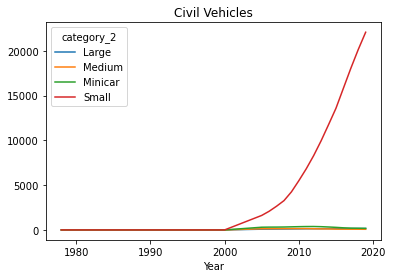

In [20]:
indicator = 'Civil Vehicles'
df = socioecon[socioecon['indicator']==indicator]
df = df[(df['Region']=='China')&(df['category_1']=='Passenger Vehicles')]
df = df[['category_2', 'Year', 'value']]
df = df[df['category_2'] != 'Total']
df = df.groupby(['category_2', 'Year']).sum()
df.reset_index(inplace=True)
pdf = pd.pivot(df, index='Year', columns='category_2', values='value')
pdf.reset_index(inplace=True)
title = indicator
lin = pdf.plot.line(x='Year', y=pdf.keys()[1:], title = title)
lin.get_figure().savefig('civil_vehicles_pass_line.svg', format='svg')

In [470]:
bal['Year'].min()

1980.0

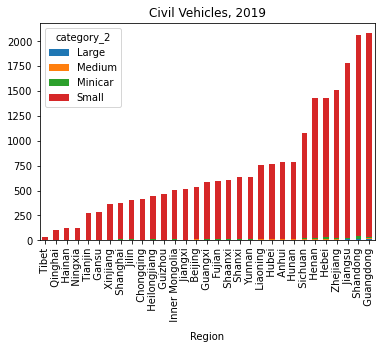

In [473]:
indicator = 'Civil Vehicles'
df = socioecon[socioecon['indicator']==indicator]
df = df[(df['Region']!='China')&(df['category_1']=='Passenger Vehicles')]
df = df[['category_2', 'Region', 'value']]
df = df[df['category_2'] != 'Total']
df = df.groupby(['category_2', 'Region']).sum()
df.reset_index(inplace=True)
pdf = pd.pivot(df, index='Region', columns='category_2', values='value')
pdf['total'] = pdf.sum(axis=1)
pdf.sort_values(by='total', inplace=True)
pdf.drop(columns=['total'], inplace=True)
pdf.reset_index(inplace=True)
title = f"{indicator}, 2019"
baar = pdf.plot.bar(x='Region', y=pdf.keys()[1:], stacked = True, title = title)
baar.get_figure().savefig('civil_vehicles_pass_bar.svg', format='svg')

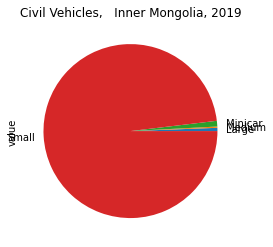

In [479]:
df = socioecon[socioecon['indicator']==indicator]
reg = df['Region'].unique()[5]

df = df[(df['Region']==reg)&(df['Year']==2019)&(df['category_1']=='Passenger Vehicles')]
df = df[(df['category_2'] != 'Total')]
df = df[['category_2', 'value']]
df = df.groupby(['category_2']).sum()
#pdf = pd.pivot(df, index='Region', columns='category_1', values='value')

title = f"{indicator}, {reg}, 2019"
piee = df.plot.pie(y='value', title = title, legend = False)
piee.get_figure().savefig('civil_vehicles_pass_pie.svg', format='svg')

<AxesSubplot:title={'center':'Civil Vehicles'}, xlabel='Year'>

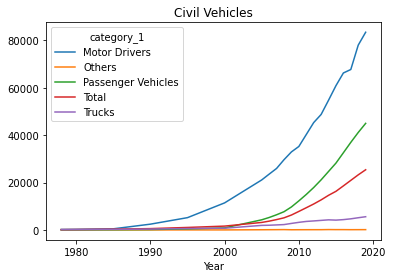

In [478]:
indicator = 'Civil Vehicles'
df = socioecon[socioecon['indicator']==indicator]
df = df[df['Region']=='China']
df = df[['category_1', 'Year', 'value']]
df = df.groupby(['category_1', 'Year']).sum()
df.reset_index(inplace=True)
pdf = pd.pivot(df, index='Year', columns='category_1', values='value')
pdf.reset_index(inplace=True)
title = indicator
pdf.plot.line(x='Year', y=pdf.keys()[1:], title = title)

<AxesSubplot:title={'center':'Farm Machinery'}, xlabel='Region'>

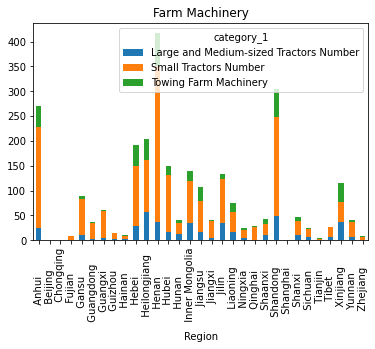

In [347]:
indicator = 'Farm Machinery'
df = socioecon[socioecon['indicator']==indicator]
df = df[df['Region']!='China']
df = df[['category_1', 'Region', 'value']]
pdf = pd.pivot(df, index='Region', columns='category_1', values='value')
pdf.reset_index(inplace=True)
title = indicator
pdf.plot.bar(x='Region', y=pdf.keys()[1:], stacked = True, title = title)

<AxesSubplot:title={'center':'Farm Machinery'}, ylabel='value'>

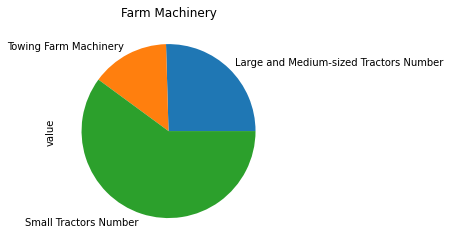

In [348]:
indicator = 'Farm Machinery'
df = socioecon[socioecon['indicator']==indicator]
df = df[(df['Region']==df['Region'].unique()[5])&(df['Year']==2019)]
df = df[['category_1', 'value']]
df.set_index('category_1', inplace=True)
#pdf = pd.pivot(df, index='Region', columns='category_1', values='value')
#df.reset_index(inplace=True)
title = indicator
df.plot.pie(y='value', title = title, legend = False)

In [376]:
socioecon

,file_name,table_name,indicator,category_1,category_2,category_3,Region,region_type,Year,value,units
0,Agriculture_农业,12-4 Major Agricultural Machin,Total Power of Agricultural Machinery,NaN,NaN,NaN,China,Country,1978.0,1.174991e+04,10 000 kw
1,Agriculture_农业,12-4 Major Agricultural Machin,Total Power of Agricultural Machinery,NaN,NaN,NaN,China,Country,1980.0,1.474575e+04,10 000 kw
2,Agriculture_农业,12-4 Major Agricultural Machin,Total Power of Agricultural Machinery,NaN,NaN,NaN,China,Country,1985.0,2.091255e+04,10 000 kw
3,Agriculture_农业,12-4 Major Agricultural Machin,Total Power of Agricultural Machinery,NaN,NaN,NaN,China,Country,1990.0,2.870770e+04,10 000 kw
4,Agriculture_农业,12-4 Major Agricultural Machin,Total Power of Agricultural Machinery,NaN,NaN,NaN,China,Country,1995.0,3.611805e+04,10 000 kw
...,...,...,...,...,...,...,...,...,...,...,...
16478,Transportation_交通,16-30 Civil Aviation Traffic a,Flying Time of General Aviation,Total,NaN,NaN,China,Country,2019.0,1.065011e+06,hr
16479,Transportation_交通,16-30 Civil Aviation Traffic a,Flying Time of General Aviation,Flight for Agriculture and Forestry Operation,Total,NaN,China,Country,2019.0,NaN,hr
16480,Transportation_交通,16-30 Civil Aviation Traffic a,Flying Time of General Aviation,Flight for Agriculture and Forestry Operation,Forest Protection Service,NaN,China,Country,2019.0,NaN,hr
16481,Transportation_交通,16-30 Civil Aviation Traffic a,Flying Time of General Aviation,Flight for Agriculture and Forestry Operation,Afforestation,NaN,China,Country,2019.0,NaN,hr


In [381]:
socioecon[socioecon['indicator']=='Civil Vehicles']

,file_name,table_name,indicator,category_1,category_2,category_3,Region,region_type,Year,value,units
15005,Transportation_交通,16-20 Possession of Civil Vehi,Civil Vehicles,Total,NaN,NaN,China,Country,1978.0,135.8400,10 000 units
15006,Transportation_交通,16-20 Possession of Civil Vehi,Civil Vehicles,Total,NaN,NaN,China,Country,1980.0,178.2900,10 000 units
15007,Transportation_交通,16-20 Possession of Civil Vehi,Civil Vehicles,Total,NaN,NaN,China,Country,1985.0,321.1200,10 000 units
15008,Transportation_交通,16-20 Possession of Civil Vehi,Civil Vehicles,Total,NaN,NaN,China,Country,1990.0,551.3600,10 000 units
15009,Transportation_交通,16-20 Possession of Civil Vehi,Civil Vehicles,Total,NaN,NaN,China,Country,1995.0,1040.0000,10 000 units
...,...,...,...,...,...,...,...,...,...,...,...
15728,Transportation_交通,16-20 Possession of Civil Vehi,Civil Vehicles,Motor Drivers,Automobile Drivers,NaN,Shaanxi,Province,2019.0,1105.0146,10 000 persons
15729,Transportation_交通,16-20 Possession of Civil Vehi,Civil Vehicles,Motor Drivers,Automobile Drivers,NaN,Gansu,Province,2019.0,569.1807,10 000 persons
15730,Transportation_交通,16-20 Possession of Civil Vehi,Civil Vehicles,Motor Drivers,Automobile Drivers,NaN,Qinghai,Province,2019.0,155.4677,10 000 persons
15731,Transportation_交通,16-20 Possession of Civil Vehi,Civil Vehicles,Motor Drivers,Automobile Drivers,NaN,Ningxia,Province,2019.0,212.9491,10 000 persons


In [ ]:
#make list of breakdown indicators
#these are indicators or categories that cannot be represented


#make list of default indicators

In [120]:
metadata = []

for row in class_df.index[0:10]:
    df = socioecon.copy()
    for i, item in enumerate(class_df.iloc[row][:-1]):
        if str(item) != 'nan':
            df = df[df[df.keys()[i]]==class_df.iloc[row, i]]

    #identify widget types
    widget_list = []

    #Line chart for temporal series (over 5 consecutive years), x axis always 'year', never stacked???
    if len(df['Year'].unique()) > 1:
        widget_list.append('line')

    #Bar chart for many regions or non-continuous time series
    if len(df['Region'].unique()) > 1:
        widget_list.append('bar')

    #Choropleth map, 
    if 'Province' in df['region_type'].unique():
        if list(df['region_type']).count('Province') > 10:
            widget_list.append('map')

    #Pie Chart when only one year, one region, and multiple cat1 are available

    #Always table
    widget_list.append('table')

    class_list = ['group', 'subgroup', 'indicator', 'cat1', 'cat2', 'cat3', 'cat4']
    class_dict = {}
    for i, item in enumerate(class_df.iloc[row][:-1]):
        if str(item) != 'nan':
            class_dict[class_list[i]] = class_df.iloc[row,i].replace(' ', '-').lower()
    del class_dict[list(class_dict.keys())[-1]]



    ind_dict = {
        'id': class_df.iloc[row,2].replace(' ', '-').lower(),
        'type': list(class_dict.keys())[-1],
        'default': True,
        #'breakdown': False, #whether this indicator/category can be plotted or it's a breakdown and its categories should be plotted
        'widget': widget_list,
        'attributes': {
            'name_en': class_df.iloc[row,2],
            'name_cn': class_df.iloc[row,2],
            'classification_en': class_dict,
            'classification_cn': class_dict,
            'units_en': list(df['units'].unique()),
            'units_cn': list(df['units'].unique())
        }
    }
    if list(class_dict.keys())[-1] == 'indicator' : ind_dict['attributes']['description'] = 'this is the indicator description'
    metadata.append(ind_dict)

In [156]:
socioecon.keys()

Index(['file_name', 'table_name', 'indicator', 'category_1', 'category_2',
       'category_3', 'Region', 'region_type', 'Year', 'value', 'units'],
      dtype='object')

In [216]:
ind_list = []
for file in socioecon['file_name'].unique()[0:1]:
    fdf = socioecon[socioecon['file_name']==file]
    for table in fdf['table_name'].unique()[0:3]:
        tdf = fdf[fdf['table_name']==table]
        for indicator in tdf['indicator'].unique():
            idict = {'indicator': indicator,
                     'classification': {'group': file,
                                        'subgroup': table}
                    }
            df = tdf[tdf['indicator']==indicator]
            wlist = []
            wdict = {}
            
            #check if time series
            reg_time = []
            reg_cat = []
            
            for reg in df['Region'].unique():
                rdf = df[df['Region']==reg]
                if len(rdf['Year'].unique()) > 1: #and sum(rdf['Year']) == (max(rdf['Year'])*(max(rdf['Year'])))/2:
                    reg_time.append(reg)
                else:
                    reg_cat.append(reg)
            
            if len(reg_time) != len(df['Region'].unique()):
                wdict['type']='line'
                wdict['x_values']='Year'
                
                if sum(rdf['Year']) == (max(rdf['Year'])*(max(rdf['Year'])+1))/2:
                    wdict['draw_line'] = True
                else:
                    wdict['draw_line'] = False
                
                
                wdict['conditional'] = {'Region': reg_time}
                if len(reg_time) == 1:
                    wdict['subtitle'] = f'in {reg_time[0]}'
                else:
                    wdict['geo_filter'] = True
            
                wlist.append(wdict)
                wdict={}
            
            #let's go for bars
            if len(reg_cat) > 1: #and len(reg_cat) == len(df['Region'].unique())-len(reg_time):
                wdict['type'] = 'bar'
                wdict['geo_filter'] = True
                wdict['x_values'] = 'Region'
                
                if len(df[df['Region'].isin(reg_cat)]['region_type'].unique()) == 1:
                    wdict['subtitle'] = f"per {df[df['Region'].isin(reg_cat)]['region_type'].unique()[0]}"
                    wdict['conditional'] = {'region_type': list(df[df['Region'].isin(reg_cat)]['region_type'].unique())}
                wlist.append(wdict)
            idict['widgets'] = wlist
            
            ind_list.append(idict)
#df.groupby(['indicator', 'category_1', 'category_2', 'category_3'], sort=False, as_index=False, dropna=False).size()

pprint.pprint(ind_list)

[{'indicator': 'Total Power of Agricultural Machinery',
  'classification': {'group': 'Agriculture_农业',
                     'subgroup': '12-4  Major Agricultural Machin'},
  'widgets': [{'type': 'line',
               'x_values': 'Year',
               'draw_line': False,
               'conditional': {'Region': ['China']},
               'subtitle': 'in China'},
              {'type': 'bar',
               'geo_filter': True,
               'x_values': 'Region',
               'subtitle': 'per Province',
               'conditional': {'region_type': ['Province']}}]},
 {'indicator': 'Farm Machinery',
  'classification': {'group': 'Agriculture_农业',
                     'subgroup': '12-4  Major Agricultural Machin'},
  'widgets': [{'type': 'line',
               'x_values': 'Year',
               'draw_line': False,
               'conditional': {'Region': ['China']},
               'subtitle': 'in China'},
              {'type': 'bar',
               'geo_filter': True,
               

In [215]:
tdf

,file_name,table_name,indicator,category_1,category_2,category_3,Region,region_type,Year,value,units
520,Agriculture_农业,"12-6 Irrigation, Reservoirs, F",Irrigated Areas,Number of Irrigated Areas over 10 000 Mu (set),NaN,NaN,China,Country,2000.0,5683.000,Number
521,Agriculture_农业,"12-6 Irrigation, Reservoirs, F",Irrigated Areas,Number of Irrigated Areas over 10 000 Mu (set),NaN,NaN,China,Country,2005.0,5860.000,Number
522,Agriculture_农业,"12-6 Irrigation, Reservoirs, F",Irrigated Areas,Number of Irrigated Areas over 10 000 Mu (set),NaN,NaN,China,Country,2010.0,5795.000,Number
523,Agriculture_农业,"12-6 Irrigation, Reservoirs, F",Irrigated Areas,Number of Irrigated Areas over 10 000 Mu (set),NaN,NaN,China,Country,2015.0,7773.000,Number
524,Agriculture_农业,"12-6 Irrigation, Reservoirs, F",Irrigated Areas,Number of Irrigated Areas over 10 000 Mu (set),NaN,NaN,China,Country,2018.0,7881.000,Number
...,...,...,...,...,...,...,...,...,...,...,...
629,Agriculture_农业,"12-6 Irrigation, Reservoirs, F",Area of Land Protected by Dikes,NaN,NaN,NaN,China,Country,2005.0,4412.000,10 000 hectares
630,Agriculture_农业,"12-6 Irrigation, Reservoirs, F",Area of Land Protected by Dikes,NaN,NaN,NaN,China,Country,2010.0,4683.100,10 000 hectares
631,Agriculture_农业,"12-6 Irrigation, Reservoirs, F",Area of Land Protected by Dikes,NaN,NaN,NaN,China,Country,2015.0,4084.400,10 000 hectares
632,Agriculture_农业,"12-6 Irrigation, Reservoirs, F",Area of Land Protected by Dikes,NaN,NaN,NaN,China,Country,2018.0,4140.921,10 000 hectares


In [163]:
{'widget': [
    {'type': 'line',
     'subtitle': 'in China',
     'geo_filter': False,
    'x_values': 'year',
    'breakdown': 'cat1',
    'stacked': False,
    'conditional': 'region=China'},
    {'type': 'bar',
     'subtitle': 'per Region',
     'geo_filter': False,
    'x_values': 'region',
    'sort_x': 'value', #alphabetical
    'breakdown': 'cat1',
    'stacked': True,
    'conditional': 'region_type=Province'}
]}

{'widget': [{'type': 'line',
   'subtitle': 'in China',
   'geo_filter': False,
   'x_values': 'year',
   'breakdown': 'cat1',
   'stacked': False,
   'conditional': 'region=China'},
  {'type': 'bar',
   'subtitle': 'per Region',
   'geo_filter': False,
   'x_values': 'region',
   'sort_x': 'value',
   'breakdown': 'cat1',
   'stacked': True,
   'conditional': 'region_type=Province'}]}

In [ ]:
{'type': #chart type (line, pie, map, bar, table),
'conditional': #filter data prior to plotting
'filter': #dropdown menu; e.g., provinces
'series': #if any, identify level of individual series
'stacked': #boolean
'x_values': #variable in x-axis, either year or regions
'sort_x': #when x_values are strings, 'value' or 'alphabetical'
}

In [47]:
for row in class_df.index[0: 1]:
    df = socioecon.copy()
    for i, item in enumerate(class_df.iloc[row][:-1]):
        if str(item) != 'nan':
            df = df[df[df.keys()[i]]==class_df.iloc[row, i]]

In [618]:
socioecon.keys()

Index(['file_name', 'table_name', 'indicator', 'category_1', 'category_2',
       'category_3', 'Region', 'region_type', 'Year', 'value', 'units', 'line',
       'pie', 'bar', 'choropleth'],
      dtype='object')

In [789]:
import geopandas as gpd